In [1]:
# -*- coding: utf-8 -*-
"""Utilities for preprocessing sequence data.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import random
from six.moves import range

from keras.utils.data_utils import Sequence


def pad_sequences(sequences, maxlen=None, dtype='int32',
                  padding='pre', truncating='pre', value=0.):
    """Pads each sequence to the same length (length of the longest sequence).
    If maxlen is provided, any sequence longer
    than maxlen is truncated to maxlen.
    Truncation happens off either the beginning (default) or
    the end of the sequence.
    Supports post-padding and pre-padding (default).
    # Arguments
        sequences: list of lists where each element is a sequence
        maxlen: int, maximum length
        dtype: type to cast the resulting sequence.
        padding: 'pre' or 'post', pad either before or after each sequence.
        truncating: 'pre' or 'post', remove values from sequences larger than
            maxlen either in the beginning or in the end of the sequence
        value: float, value to pad the sequences to the desired value.
    # Returns
        x: numpy array with dimensions (number_of_sequences, maxlen)
    # Raises
        ValueError: in case of invalid values for `truncating` or `padding`,
            or in case of invalid shape for a `sequences` entry.
    """
    if not hasattr(sequences, '__len__'):
        raise ValueError('`sequences` must be iterable.')
    lengths = []
    for x in sequences:
        if not hasattr(x, '__len__'):
            raise ValueError('`sequences` must be a list of iterables. '
                             'Found non-iterable: ' + str(x))
        lengths.append(len(x))

    num_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    x = (np.ones((num_samples, maxlen) + sample_shape) * value).astype(dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x


def make_sampling_table(size, sampling_factor=1e-5):
    """Generates a word rank-based probabilistic sampling table.
    This generates an array where the ith element
    is the probability that a word of rank i would be sampled,
    according to the sampling distribution used in word2vec.
    The word2vec formula is:
        p(word) = min(1, sqrt(word.frequency/sampling_factor) / (word.frequency/sampling_factor))
    We assume that the word frequencies follow Zipf's law (s=1) to derive
    a numerical approximation of frequency(rank):
       frequency(rank) ~ 1/(rank * (log(rank) + gamma) + 1/2 - 1/(12*rank))
        where gamma is the Euler-Mascheroni constant.
    # Arguments
        size: int, number of possible words to sample.
        sampling_factor: the sampling factor in the word2vec formula.
    # Returns
        A 1D Numpy array of length `size` where the ith entry
        is the probability that a word of rank i should be sampled.
    """
    gamma = 0.577
    rank = np.arange(size)
    rank[0] = 1
    inv_fq = rank * (np.log(rank) + gamma) + 0.5 - 1. / (12. * rank)
    f = sampling_factor * inv_fq

    return np.minimum(1., f / np.sqrt(f))


def skipgrams(sequence, vocabulary_size,
              window_size=4, negative_samples=1., shuffle=True,
              categorical=False, sampling_table=None, seed=None):
    """Generates skipgram word pairs.
    Takes a sequence (list of indexes of words),
    returns couples of [word_index, other_word index] and labels (1s or 0s),
    where label = 1 if 'other_word' belongs to the context of 'word',
    and label=0 if 'other_word' is randomly sampled
    # Arguments
        sequence: a word sequence (sentence), encoded as a list
            of word indices (integers). If using a `sampling_table`,
            word indices are expected to match the rank
            of the words in a reference dataset (e.g. 10 would encode
            the 10-th most frequently occurring token).
            Note that index 0 is expected to be a non-word and will be skipped.
        vocabulary_size: int. maximum possible word index + 1
        window_size: int. actually half-window.
            The window of a word wi will be [i-window_size, i+window_size+1]
        negative_samples: float >= 0. 0 for no negative (=random) samples.
            1 for same number as positive samples. etc.
        shuffle: whether to shuffle the word couples before returning them.
        categorical: bool. if False, labels will be
            integers (eg. [0, 1, 1 .. ]),
            if True labels will be categorical eg. [[1,0],[0,1],[0,1] .. ]
        sampling_table: 1D array of size `vocabulary_size` where the entry i
            encodes the probability to sample a word of rank i.
        seed: random seed.
    # Returns
        couples, labels: where `couples` are int pairs and
            `labels` are either 0 or 1.
    # Note
        By convention, index 0 in the vocabulary is
        a non-word and will be skipped.
    """
    couples = []
    labels = []
    for i, wi in enumerate(sequence):
        if not wi:
            continue
        if sampling_table is not None:
            if sampling_table[wi] < random.random():
                continue

        window_start = max(0, i - window_size)
        window_end = min(len(sequence), i + window_size + 1)
        for j in range(window_start, window_end):
            if j != i:
                wj = sequence[j]
                if not wj:
                    continue
                couples.append([wi, wj])
                if categorical:
                    labels.append([0, 1])
                else:
                    labels.append(1)

    if negative_samples > 0:
        num_negative_samples = int(len(labels) * negative_samples)
        words = [c[0] for c in couples]
        random.shuffle(words)

        couples += [[words[i % len(words)],
                    random.randint(1, vocabulary_size - 1)] for i in range(num_negative_samples)]
        if categorical:
            labels += [[1, 0]] * num_negative_samples
        else:
            labels += [0] * num_negative_samples

    if shuffle:
        if seed is None:
            seed = random.randint(0, 10e6)
        random.seed(seed)
        random.shuffle(couples)
        random.seed(seed)
        random.shuffle(labels)

    return couples, labels


def _remove_long_seq(maxlen, seq, label):
    """Removes sequences that exceed the maximum length.
    # Arguments
        maxlen: int, maximum length
        seq: list of lists where each sublist is a sequence
        label: list where each element is an integer
    # Returns
        new_seq, new_label: shortened lists for `seq` and `label`.
    """
    new_seq, new_label = [], []
    for x, y in zip(seq, label):
        if len(x) < maxlen:
            new_seq.append(x)
            new_label.append(y)
    return new_seq, new_label


class TimeseriesGenerator(Sequence):
    """Utility class for generating batches of temporal data.
    This class takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    stride, length of history etc., to produce batches for
    training/validation.
    # Arguments
        data: indexable generator (such as list or Numpy array)
            containing consecutive data points.
        targets: targets corresponding to instances in `data`.
            Should have same length as `data`.
        length: length of history to consider for prediction.
            `data[i-length : i+1]` is used to prepare the input.
        sampling_rate: period between successive individual data
            points. For rate `r`, points
            `data[i]`, `data[i-r]`, ... `data[i - length]`
            are used as input.
        stride: period between successive sub-sequences used for
            training. For stride `s`, consecutive training samples would
            be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, ...
        start_index, end_index: delimiters for sub-sets of `data` & `targets`
            to be used for batch generation. Useful to reserve part of
            data for validation.
        shuffle: whether to shuffle training samples, or draw them in
            chronological order.
        reverse: if `true`, input points are provided in reverse order.
        batch_size: number of timeseries samples in each batch
            (except maybe last one)
    # Returns
        A `Sequence` instance.
    # Examples
    ```data = np.array([[i] for i in range(50)])
       targets = np.array([[i] for i in range(50)])
       data_gen = TimeseriesGenerator(data, targets,
                                      length=10, sampling_rate=2,
                                      batch_size=2)
       assert len(data_gen) == 20
       assert (np.array_equal(data_gen[0][0],
                              np.array([[[0], [2], [4], [6], [8]],
                                        [[1], [3], [5], [7], [9]]])))
       assert (np.array_equal(data_gen[0][1],
                              np.array([[10], [11]])))
    ```
    """

    def __init__(self, data, targets,
                 length,
                 sampling_rate=1,
                 stride=1,
                 start_index=0,
                 end_index=None,
                 shuffle=False,
                 reverse=False,
                 batch_size=128):
        self.data = data
        self.targets = targets
        self.length = length
        self.sampling_rate = sampling_rate
        self.stride = stride
        self.start_index = start_index + length - 1
        if end_index is None:
            end_index = len(data) - 1
        self.end_index = end_index
        self.shuffle = shuffle
        self.reverse = reverse
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(
            (self.end_index + 1 - self.start_index) /
            (self.batch_size * self.stride)))

    def _empty_batch(self, num_rows):
        samples_shape = [num_rows, self.length // self.sampling_rate]
        samples_shape.extend(self.data.shape[1:])
        targets_shape = [num_rows]
        targets_shape.extend(self.targets.shape[1:])
        return np.empty(samples_shape), np.empty(targets_shape)
    
    def __get_single_item(self, index):
        if self.shuffle:
                rows = np.random.randint(
                    self.start_index, self.end_index, size=self.batch_size)
        else:
            i = self.start_index + self.batch_size * self.stride * index
            rows = np.arange(i, min(i + self.batch_size *
                                    self.stride, self.end_index + 1), self.stride)

        samples, targets = self._empty_batch(len(rows))
        for j, row in enumerate(rows):
            indices = range(rows[j] - self.length + 1, rows[j] + 1, self.sampling_rate)
            samples[j] = self.data[indices]
            targets[j] = self.targets[rows[j]]
        if self.reverse:
            return samples[:, ::-1, ...], targets
        return samples, targets

    def __getitem__(self, index):
        if isinstance(index, slice):
            if index.step == None:
                step = 1
            else:
                step = index.step
            if index.start == None:
                start = 0
            else:
                start = index.start
            if index.stop == None:
                stop = len(self)
            else:
                stop = index.stop
            print(start, stop, step)
            X, Y = [], []
            for idx in range(start, stop, step):
                x, y = self.__get_single_item(idx)
                X.append(x)
                Y.append(y)
            return np.array(X), np.array(Y)
        elif isinstance(index, int):
            return self.__get_single_item(index)
        else:
            raise TypeError("Invalid argument type.")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def SplitGenerator(data, targets, length, sampling_rate = 1, stride = 1, start_index = 0, end_index = None, 
                   shuffle = False, reverse = False, batch_size = 128, test_size = 0.2):
    assert (type(data) == np.ndarray), 'Data should be numpy.ndarray'
    assert (type(targets) == np.ndarray), 'Targets should be numpy.ndarray'
    data = data[(data.shape[0] - length + 1) % (batch_size * stride) : ]
    targets = targets[-data.shape[0] : ]
    train_size = 1 - test_size
    num_batches = (data.shape[0] - length + 1) / (batch_size * stride)
    num_train_batches = round(num_batches * train_size)
    train_len  = int(num_train_batches * stride * batch_size + length - 1)
    train_data = data[ : train_len]
    train_targets = targets[ : train_len]
    num_test_batches = num_batches - num_train_batches
    test_len = int(num_test_batches * stride * batch_size + length - 1)
    test_data = data[-test_len : ]
    test_targets = targets[-test_len : ]
    train_gen = TimeseriesGenerator(train_data, train_targets, length, sampling_rate, stride, start_index, 
                                   end_index, shuffle, reverse, batch_size)
    test_gen = TimeseriesGenerator(test_data, test_targets, length, sampling_rate, stride, start_index, 
                                   end_index, shuffle, reverse, batch_size)
    return train_gen, test_gen

<h1>Usage</h1>

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


data_name = 'Si_2'
df = pd.read_csv('data/{}.csv'.format(data_name))
y = df.y
X_old = df.drop(['y', 'date'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_old)


length = 1
batch_size = 512
train, test = SplitGenerator(X_scaled, y.values, length = length, sampling_rate = 1, stride = 1,
                             batch_size = batch_size, shuffle = False)

In [10]:
print(len(test))
test[:2]

9
0 2 1


(array([[[[-1.15011166e-02,  9.86345028e-04, -1.04923663e-01, ...,
            3.33279927e-02,  2.68153794e-01,  7.44132499e-01]],
 
         [[-3.51040763e-01, -3.48868727e-01, -6.09740819e-03, ...,
           -2.73209914e-02,  2.66636931e-01,  9.20567965e-01]],
 
         [[-4.88629922e-02,  1.11497122e-02, -4.29593855e-02, ...,
           -3.04127741e-02,  2.67140762e-01,  1.09700343e+00]],
 
         ...,
 
         [[-3.28215842e-01, -4.24196426e-01,  1.51291431e-02, ...,
           -1.53934554e-01, -1.06125153e-02, -8.43786687e-01]],
 
         [[-3.06703865e-01, -3.21839772e-01,  8.78484738e-02, ...,
           -1.53192697e-01, -1.01201560e-02, -6.67351222e-01]],
 
         [[ 6.08133570e-02,  1.04364811e-01,  2.00516588e-02, ...,
           -1.92701873e-01, -9.93987828e-03, -4.90915757e-01]]],
 
 
        [[[ 2.21417902e-01,  2.45190382e-01,  3.62124391e-02, ...,
           -1.96074371e-01, -1.00270070e-02, -3.14480292e-01]],
 
         [[-2.06832008e-01, -2.33438934e-01,  1.76


Epoch 00001: val_loss improved from inf to 1.06375, saving model to /tmp/weights.hdf5

Epoch 00002: val_loss improved from 1.06375 to 0.91453, saving model to /tmp/weights.hdf5

Epoch 00003: val_loss improved from 0.91453 to 0.84594, saving model to /tmp/weights.hdf5

Epoch 00004: val_loss improved from 0.84594 to 0.80577, saving model to /tmp/weights.hdf5

Epoch 00005: val_loss improved from 0.80577 to 0.77746, saving model to /tmp/weights.hdf5

Epoch 00006: val_loss improved from 0.77746 to 0.75857, saving model to /tmp/weights.hdf5

Epoch 00007: val_loss improved from 0.75857 to 0.74394, saving model to /tmp/weights.hdf5

Epoch 00008: val_loss improved from 0.74394 to 0.73478, saving model to /tmp/weights.hdf5

Epoch 00009: val_loss improved from 0.73478 to 0.72610, saving model to /tmp/weights.hdf5

Epoch 00010: val_loss improved from 0.72610 to 0.72073, saving model to /tmp/weights.hdf5

Epoch 00011: val_loss improved from 0.72073 to 0.71429, saving model to /tmp/weights.hdf5

Ep

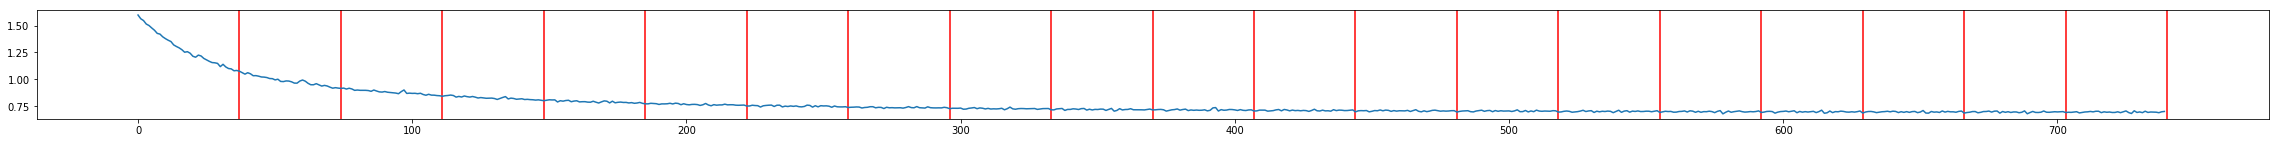

In [15]:
from keras.layers import Input, Dense, Dropout, LSTM
from keras.models import Sequential
from keras import regularizers
from keras.callbacks import ModelCheckpoint, Callback
from keras.optimizers import Adam
%matplotlib inline
import matplotlib.pyplot as plt
import h5py


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        

start = 256
drop_size = 0.5
reg_size = 0.001
model = Sequential()
model.add(LSTM(units = start, activation = 'elu', stateful = False, return_sequences = False,
               batch_input_shape = (batch_size, length, X_old.shape[1]),
               kernel_regularizer=regularizers.l2(reg_size), implementation = 1,
               recurrent_regularizer = regularizers.l2(reg_size),
               recurrent_dropout = drop_size))
model.add(Dropout(drop_size))
model.add(Dense(start, activation = 'elu', kernel_regularizer=regularizers.l2(reg_size)))
model.add(Dropout(drop_size))
model.add(Dense(1, activation = 'sigmoid'))

adam = Adam(decay=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)
history = LossHistory()

num_epochs = 20
h = model.fit_generator(train, shuffle = False, epochs = num_epochs, validation_data=test, verbose = 0,
                        callbacks=[history, checkpointer])
plt.rcParams['figure.figsize'] = (num_epochs*2, int(np.sqrt(num_epochs/4)))
xcoords = [len(train)*(i+1) for i in range(num_epochs)]
for xc in xcoords:
    plt.axvline(x=xc, color='red')
plt.plot(history.losses)